In [1]:
#import dependencies
import pandas as pd
import numpy as np
import random as rn
from datetime import datetime
import gym
from keras import backend as K
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, Dense, Flatten, BatchNormalization
import tensorflow as tf
from tensorflow.losses import huber_loss
import os
from keras.utils import plot_model
from IPython.display import Image
from matplotlib import pyplot as plt
import seaborn as sns


# Add graphviz to PATH environmental variable (for NN model architecture visualizations)
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# Set randomization defaults for solution reproducability
np.random.seed(21)
rn.seed(21)
tf.set_random_seed(21)

# Set conditions for keras result reproducability
session_conf = tf.ConfigProto(intra_op_parallelism_threads = 1, inter_op_parallelism_threads = 1)
sess = tf.Session(graph = tf.get_default_graph(), config = session_conf)
K.set_session(sess)

# Set visualization defaults
sns.set_context('notebook')

%matplotlib inline 

Using TensorFlow backend.


In [2]:
env = gym.make('SpaceInvaders-v0') # Instantiate Space Invaders gym environemtn
obs = env.reset() # Initialize environment

print('Space Invaders Display Dimensions: {:} x {:} x {:}'.format(obs.shape[0], obs.shape[1], obs.shape[2]))
print('Action Space Size: {:} Options'.format(env.action_space.n))

Space Invaders Display Dimensions: 210 x 160 x 3
Action Space Size: 6 Options


In [3]:
def process_image(obs):
    img = obs[12:195:2, ::2] # Trim image to playable display domain, downsample
    img = img.mean(axis = 2) # Convert image to greyscale
    img = img.astype(np.uint8)  # Cast pixel values as integers
    img = img.reshape((1,) + img.shape + (1,)) # Reshape image to 4D array of dimensions 1 x H x L x 1 for Keras compatibility
    return img # return processed image array

Processed Image Array Dimension: 1 x 92 x 80 x 1


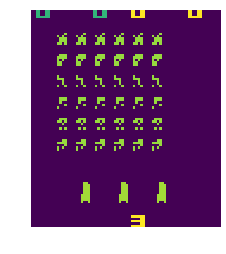

In [4]:
# Apply image processing helper function to initial environment observation
img = process_image(obs) 

# Plot image; print dimensions for 4D image array
fig = plt.figure()
ax = fig.add_subplot(111)

ax.axis("off")
plt.imshow(img.reshape(img.shape[1], img.shape[2]))

print('Processed Image Array Dimension: {:} x {:} x {:} x {:}'.format(img.shape[0], img.shape[1], img.shape[2], img.shape[3]))

In [5]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = int(maxlen)
        self.buf = np.empty(shape = self.maxlen, dtype = np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data): # Define method for storing samples in replay memory buffer
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen # If `maxlen` is exceeded, replace prior memory samples with new observations
    
    def sample(self, batch_size, with_replacement = True): # Define method for randomly sampling replay memory; default to sampling with replacement (faster than alternative)
        if with_replacement:
            indices = np.random.randint(self.length, size = batch_size)
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

# Define helper function for randomly sampling from memory buffer of class `ReplayMemory`
def sample_memories(memory_store, batch_size):
    cols = [[], [], [], [], []]
    for memory in memory_store.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [6]:
# Declare Double Deep-Q Learning Network Agent class
class DDQNAgent:
    def __init__(self, image_shape, action_space, learning_rate, rho, optimizer_epsilon, replay_memory, gamma, epsilon_max, epsilon_min, epsilon_steps):
        self.image_shape = image_shape
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.rho = rho
        self.optimizer_epsilon = optimizer_epsilon
        self.memory = replay_memory
        self.gamma = gamma
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_decay = (epsilon_max - epsilon_min)/epsilon_steps # set step size for decay from `epsilon_max` to `epsilon_min` over `epsilon_step` steps
        self.ε = epsilon_max # set initial ε-greedy learning `ε` parameter value equal to `epsilon_max`
        self.model, self.target_model = self._build_model() # instantiate core model, target model (same initial weights)
    
    def _build_model(self): # Define ANN architecture for Deep-Q Network Learning:
        model = Sequential()
        
        model.add(Conv2D(32, 8, strides = 4, padding = "valid", activation = "relu", input_shape = self.image_shape, data_format = "channels_last"))
        model.add(Conv2D(64, 4, strides = 2, padding = "valid", activation = "relu"))
        model.add(Conv2D(64, 3, strides = 1, padding = "valid", activation = "relu"))
        model.add(Flatten())
        model.add(Dense(512, activation = "relu"))
        model.add(Dense(self.action_space))
        
        model.compile(loss = huber_loss, optimizer = RMSprop(lr = self.learning_rate, rho = self.rho, epsilon = self.optimizer_epsilon))
        return model, model

    def act(self, state): # Define ε-greedy learning action method
        
        ## Apply image processing helper function to current environment state; convert image pixel values to [0,1]
        state_proc = process_image(state)
        state_scaled = state_proc/255
        
        ## Perform action based on ε value: 
        ε = max(self.epsilon_min, self.ε)
        
        ### If Agent acting randomly, select random action from available action-space
        if np.random.rand() < ε:
            return rn.randrange(self.action_space)
        
        ### If Agent not acting randomly, choose action based on policy of selecting action yielding highest Q-value
        Q_value = self.model.predict(state_scaled)[0] 
        return np.argmax(Q_value)
         
    def remember(self, state, action, reward, next_state, done): # Define method for appending agent experiences to memory buffer
        self.memory.append((state, action, reward, next_state, done)) 
       
    def train(self, batch_size): # Define method for Agent to traing DNN with experiences sampled from memory buffer
        ## Extract minibatch samples from memory buffer
        state, action, reward, next_state, done = sample_memories(self.memory, batch_size)
        
        ## Convert current, next state observation pixel values to [0,1]
        state_scaled = state/255
        next_state_scaled = next_state/255
        
        ## Update best Q value for each observation within minibatch
        for state_scaled, action, reward, next_state_scaled, done in zip(state_scaled, action, reward, next_state_scaled, done):
            
            ### Predict Q-values for current state
            Q_values = self.model.predict(state_scaled) 
            
            ### Update Q-value for selected action
            target = reward ### If training episode is complete, set Q-value for selected action equal to present reward
            if not done: ### If episode is ongoing, set Q-value for selected action discounted future Q-value predicted using target model
                target = reward + self.gamma * np.amax(self.target_model.predict(next_state_scaled)[0]) 
    
            Q_values[0][action] = target
            
        ## Fit online model on minibatch to optimize quality of Q-value prediction for selected action; update ε-greedy learning parameter value
        history = self.model.fit(state_scaled, Q_values, batch_size = batch_size, epochs = 1, verbose = 0)
        
        if self.ε > self.epsilon_min:
            self.ε -= self.epsilon_decay
            
        return history
    
    def update_target_model(self): # Define method to copy online DQN model feature weights to target model
        model_weights = self.model.get_weights()
        self.target_model.set_weights(model_weights)
        
    def save(self, name): # Define method for saving model weights
        self.model.save_weights(name)

    def load(self, name): # Define method for loading saved model weights
        self.model.load_weights(name)

In [7]:
# Set DQN Agent parameters
## Set RL environment parameters
INPUT_SHAPE = img.shape[1:]
ACTION_SPACE = env.action_space.n

# Set RMSProp optimizer learning parameters
LEARNING_RATE = 0.00025
RHO = 0.95
OPTIMIZER_EPSILON = 0.01

## Set Q-learning γ discount-rate parameter
GAMMA = 0.99

## Set replay memory size parameter; instantiate memory buffer
REPLAY_MEMORY_SIZE = 6 * 10**4
REPLAY_MEMORY = ReplayMemory(REPLAY_MEMORY_SIZE)

## Set ε-greedy learning parameters for actor-agent
EPSILON_MAX = 1
EPSILON_MIN = 0.1
DECAY_STEPS = 2 * 10**4

## Set output directory for model storage
OUTPUT_DIR = 'DDQN_model_output/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Instantiate Deep-Q Learning Agent
agent = DDQNAgent(INPUT_SHAPE, ACTION_SPACE, LEARNING_RATE, RHO, OPTIMIZER_EPSILON, REPLAY_MEMORY, GAMMA, EPSILON_MAX, EPSILON_MIN, DECAY_STEPS)

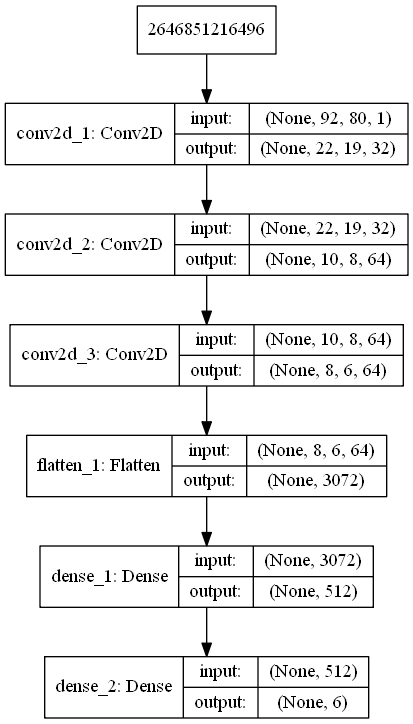

In [8]:
# Plot ANN archictecture
plot_model(agent.model, to_file = OUTPUT_DIR + 'ANN_architecture.png', show_shapes = True)
Image(retina = True, filename =  OUTPUT_DIR + 'ANN_architecture.png')

In [9]:
# Set training defaults
TOTAL_FRAMES = 2 * 10**5 # Total frames for DDQN training
SPAWN_SKIP = 40 # Frames at start of episode skipped before simulation start (no user control) 
RESPAWN_SKIP = 20 # Frames skipped after loss of life
TRAINING_START = 10**4 # Frames simulated before DDQN training begins
TRAINING_FREQUENCY = 3 # Game frames per model training step
BATCH_SIZE = 64 # Minibatch DQN SGD batch size
COPY_STEPS = 2 * 10**3 # Frames per online model -> target model copy step
SAVE_STEPS = 2 * 10**3 # Frames per trained model save

# Define dictionary for storing training performance
run_dict = {    
    'game':    [],
    'score':   [],
    'epsilon': [],
    'length':  []
}

# Define list for storing DQN training loss history
loss_history = []

# Initialize training defaults
frames = 0
game = 0
start_time = datetime.now()
game_lives = 3

# Begin training Loop
while frames < TOTAL_FRAMES:
    
    # Reset training defauls for episode
    env.reset()
    done = False
    score = 0
    length = 0
    respawn_frames = 0
    
    # Loop over frames of episode duration
    while not done:
        
        env.render() # Render game
        
        ## Skip initial frames of episode (no agent control)
        while length < SPAWN_SKIP:
            state, _, _, lives = env.step(0)
            
            lives = lives['ale.lives']
            frames += 1
            length += 1
        
        ## While agent is "alive", play game
        if game_lives == lives:
            
            ### Perform ε-greedly learning, update running score
            action = agent.act(state)
            next_state, reward, done, lives = env.step(action)
            
            lives = lives['ale.lives']
            score += reward

            ### Commit action results to agent memory buffer, update `state` variable
            agent.remember(process_image(state), action, reward, process_image(next_state), done)
            state = next_state
        
        ## After agent "dies", skip forward until sufficient "respawn frames" have passed to resume play
        else:
            state, reward, done, _ = env.step(0)
            
            respawn_frames += 1
            score += reward
            
            ### After sufficient wait time, resume gameplay 
            if respawn_frames == RESPAWN_SKIP:
                
                game_lives = lives
                respawn_frames = 0
        
        ## Update frame, game length counters
        frames += 1
        length += 1
        
        ## Repeat with fully stochastic agent actions until training start frame-threshold (`training_start`) is met
        if frames < TRAINING_START:
            continue
        
        ## Retrain model at intervals of predetermined frame frequency (`training_frequency`), store training loss
        if frames % TRAINING_FREQUENCY == 0:
            model_hist = agent.train(BATCH_SIZE) 
            loss_history.append(model_hist.history['loss'][0])
        
        ## Copy online model to target model at intervals of `copy_steps` frames
        if frames % COPY_STEPS == 0:
            agent.update_target_model()
        
        ## Save model artifact, loss history, training history at intervals of `save_steps` frames
        if frames % SAVE_STEPS == 0:
            agent.save(OUTPUT_DIR + "weights_{:03d}K_frames.hdf5".format(int(frames/SAVE_STEPS)))
            pd.Series(loss_history).to_csv(OUTPUT_DIR + 'training_loss.csv', index = False, header = False)
            pd.DataFrame.from_dict(run_dict).to_csv(OUTPUT_DIR + 'training_history.csv', index = False)
    
    # With game episode concluded, update game counter; store episode metrics; print episode result
    game += 1
    
    run_dict['game'].append(game)
    run_dict['score'].append(score)
    run_dict['epsilon'].append(agent.ε)
    run_dict['length'].append(length)

    print("Game: {:,d} ({:,d} Total Frames): Score: {:.0f} Points, Final Epsilon: {:.2f}, Game Length: {:,d} Moves".format(
        game, frames, score, agent.ε, length))   

# Record, print training duration
env.close()
end_time = datetime.now()

print('')
print("Training Time: {:}".format(end_time - start_time))

Game: 1 (744 Total Frames): Score: 155 Points, Final Epsilon: 1.00, Game Length: 744 Moves
Game: 2 (1,534 Total Frames): Score: 185 Points, Final Epsilon: 1.00, Game Length: 790 Moves
Game: 3 (2,337 Total Frames): Score: 185 Points, Final Epsilon: 1.00, Game Length: 803 Moves
Game: 4 (3,091 Total Frames): Score: 165 Points, Final Epsilon: 1.00, Game Length: 754 Moves
Game: 5 (3,993 Total Frames): Score: 120 Points, Final Epsilon: 1.00, Game Length: 902 Moves
Game: 6 (5,214 Total Frames): Score: 255 Points, Final Epsilon: 1.00, Game Length: 1,221 Moves
Game: 7 (6,421 Total Frames): Score: 360 Points, Final Epsilon: 1.00, Game Length: 1,207 Moves
Game: 8 (7,134 Total Frames): Score: 155 Points, Final Epsilon: 1.00, Game Length: 713 Moves
Game: 9 (7,786 Total Frames): Score: 110 Points, Final Epsilon: 1.00, Game Length: 652 Moves
Game: 10 (8,269 Total Frames): Score: 35 Points, Final Epsilon: 1.00, Game Length: 483 Moves
Game: 11 (8,770 Total Frames): Score: 30 Points, Final Epsilon: 1.00